In [12]:
# task 2 for Image Augmentation


对于语义分割而言，常规的数据扩增方法都会改变图像的标签。
如水平翻转、垂直翻转、旋转90%、旋转和随机裁剪，这些常见的数据扩增方法都会改变图像的标签，即会导致地标建筑物的像素发生改变。

albumentations是基于OpenCV的快速训练数据增强库，拥有非常简单且强大的可以用于多种任务（分割、检测）的接口，易于定制且添加其他框架非常方便。

albumentations也是计算机视觉数据竞赛中最常用的库：

GitHub： https://github.com/albumentations-team/albumentations
示例：https://github.com/albumentations-team/albumentations_examples



In [13]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torchvision
from torchvision import transforms as T
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import albumentations as A
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

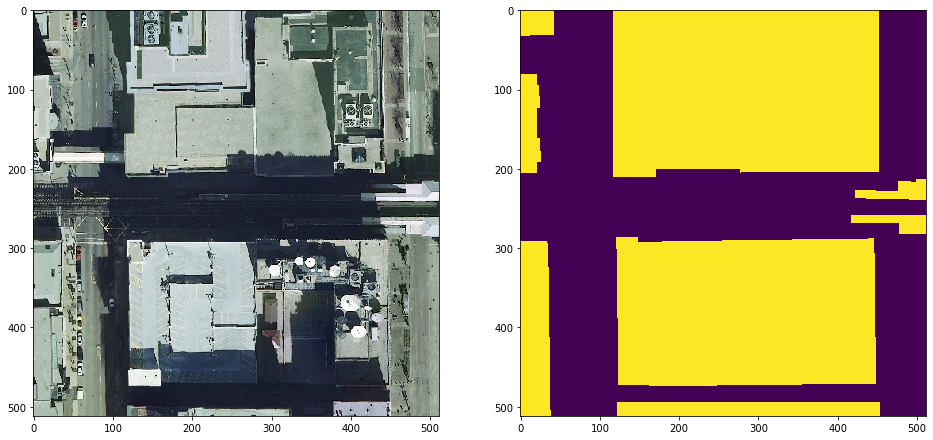

In [14]:
# original image

train_mask = pd.read_csv('train_mask.csv', sep='\t', names=['name', 'mask'])
train_mask['name'] = train_mask['name'].apply(lambda x: './train/' + x)

img = cv2.imread(train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(mask)


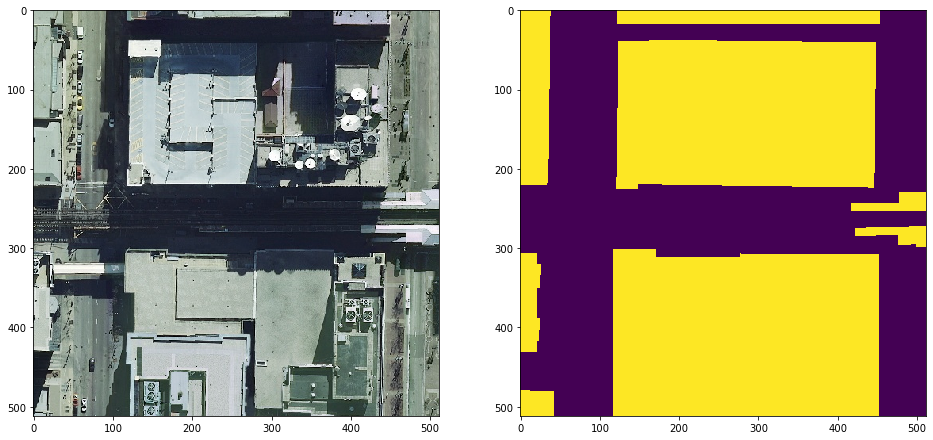

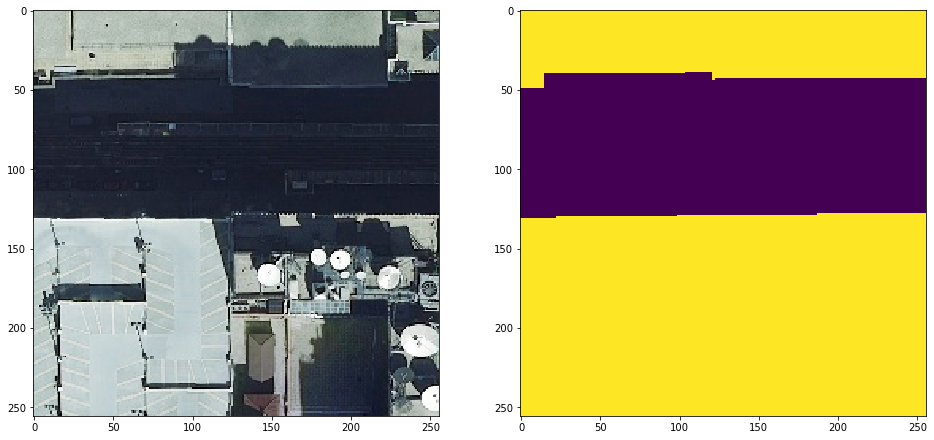

In [15]:
# 垂直翻转
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.flip(img, 0))

plt.subplot(1, 2, 2)
plt.imshow(cv2.flip(mask, 0))
# 随机裁剪
x, y = np.random.randint(0, 256), np.random.randint(0, 256)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img[x:x+256, y:y+256])

plt.subplot(1, 2, 2)
plt.imshow(mask[x:x+256, y:y+256])

albumentations数据扩增



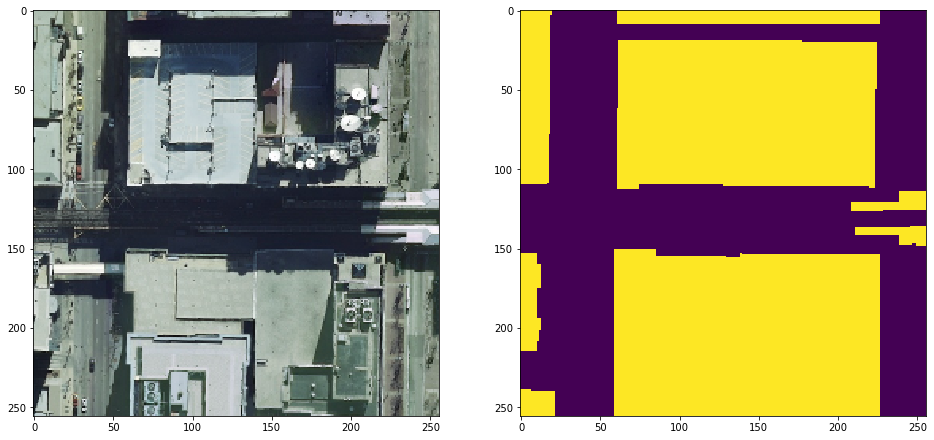

In [16]:
trfm = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
])

augments = trfm(image=img, mask=mask)
img_aug, mask_aug = augments['image'], augments['mask']
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(augments['image'])

plt.subplot(1, 2, 2)
plt.imshow(augments['mask'])

In [17]:
import torch.utils.data as D
class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.len = len(paths)

    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        mask = rle_decode(self.rles[index])
        augments = self.transform(image=img, mask=mask)
        return self.as_tensor(augments['image']), augments['mask'][None]
   
    def __len__(self):
        return self.len


In [18]:
P = 1
trfm = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=P),
    A.VerticalFlip(p=P),
    A.RandomRotate90(),
])

dataset = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm
)
loader = D.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=0)